In [14]:
import glob
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from pyproj import Proj, transform, Transformer
import numpy as np
import netCDF4 as nc

In [12]:
def plot_rgb(rgb_paths, ortho_path, extent_1, extent_2, points):
    
    
    # create a matplotlib figure
    fig = plt.figure(figsize=(15, 10))
    
    # open the individual rgb landsat files
    with rasterio.open(rgb_paths[0]) as src_red,\
         rasterio.open(rgb_paths[1]) as src_green,\
         rasterio.open(rgb_paths[2]) as src_blue:
        
        # Read each band
        red_band = src_red.read(1)
        green_band = src_green.read(1)
        blue_band = src_blue.read(1)

        # Stack bands into an RGB array
        rgb = np.stack((red_band, green_band, blue_band), axis=-1)

        # Normalize the bands for better visualization
        rgb = rgb / rgb.max()
        rgb *= 1.6
        rgb[rgb>1] = 1

        # Define the coordinate reference system from the metadata
        crs1 = ccrs.epsg(src_red.crs.to_epsg())

    # add subplot with projection for plotting imagery
    ax1 = fig.add_subplot(1, 2, 1, projection=crs1)
    
    # plot zoomed image extent
    ax1.imshow(rgb, origin='upper', extent=[src_red.bounds.left, src_red.bounds.right, 
                                           src_red.bounds.bottom, src_red.bounds.top], 
                                           transform=crs1)
    
    # Apply the extent
    ax1.set_extent(extent_1, crs=ccrs.PlateCarree())

    # Add grid lines with labels
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-50.7, -50.4,-50.1])
    gl.ylocator = mticker.FixedLocator([70.55, 70.45,70.35])
    gl.xlabel_style = {'rotation': 0,'size': 15}
    gl.ylabel_style = {'rotation': 0,'size': 15}
    
    # define custom formatter function to filter out specific labels
    def customformatter(lat,pos):
        if lat == 70.55:  # Specify the longitude label you want to hide
            return ''   # Return empty string for -90 degrees longitude
        return f'{lat}°E'

    # Set the custom formatter for longitude
    gl.yformatter = (mticker.FuncFormatter(customformatter))
    
    # add subplot with projection for plotting Greenland shape
    projection = ccrs.Stereographic(central_latitude=70, central_longitude=-50)

    # Adding an inset to the first subplot
    ax0 = inset_axes(ax1, width="100%", height="100%", loc="upper left", 
                 bbox_to_anchor=(-0.05,0.75,.3,.3), axes_class=GeoAxes,
                 axes_kwargs=dict(projection=projection), bbox_transform=ax1.transAxes)  # [x, y, width, height] in relative figure coordinates
     
    # Set the extent around Greenland
    rect = [-57.5, -45.5, 67.5, 72.25]
    ax0.set_extent((rect), crs=ccrs.PlateCarree())

    # Set the ocean to light blue
    ax0.add_feature(cfeature.OCEAN, color='lightblue')

    # Add ice cover in pale grey
    # We use the Natural Earth data for physical features which includes ice sheets
    ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'glaciated_areas', '10m',
                                                edgecolor='none', facecolor='whitesmoke'))

    # Set the unglaciated land to dark grey
    ax0.add_feature(cfeature.LAND, color='darkgray')

    # Add coastlines for better edge definition
    ax0.coastlines(resolution='10m')
    
    # Add grid lines with labels
    gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='black', alpha=0.5, linestyle='--')
    gl.bottom_labels = False
    gl.right_labels = False
    gl.y_inline = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 0,'size': 15,'ha': 'center'}
    gl.ylabel_style = {'rotation': 0,'size': 15}#,'va': 'center','ha': 'left'}
    gl.xlocator = mticker.FixedLocator([-56, -52,-48])
    gl.ylocator = mticker.FixedLocator([68, 70, 72])
    gl.xpadding = 12 

    # Add a red rectangle for the specified bounds
    rectangle = mpatches.Rectangle((extent_1[0], extent_1[2]), extent_1[1] - extent_1[0], extent_1[3] - extent_1[2],
                                   fill=False, edgecolor='red', linewidth=2, 
                                   transform=ccrs.PlateCarree(),zorder=10)
    
    ax0.add_patch(rectangle)
    
     # Open the individual files
    with rasterio.open(ortho_path) as src:
    
        # Read each band
        red_band = src.read(1)
        green_band = src.read(2)
        blue_band = src.read(3)

        # Stack bands into an RGB array
        rgb = np.stack((red_band, green_band, blue_band), axis=-1)

        # Normalize the bands for better visualization
        rgb = rgb / rgb.max()
        rgb *= 2
        rgb[rgb>1] = 1

        # Define the coordinate reference system from the metadata
        crs2 = ccrs.epsg(src.crs.to_epsg())

    # add subplot with projection for plotting imagery
    ax2 = fig.add_subplot(1, 2, 2, projection=crs2)
    
    # plot zoomed image extent
    ax2.imshow(rgb, origin='upper', extent=[src.bounds.left, src.bounds.right, 
                                           src.bounds.bottom, src.bounds.top], 
                                           transform=crs2)
    
    # Apply the extent
    ax2.set_extent(extent_2, crs=ccrs.PlateCarree())

    # Add grid lines with labels
    gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-50.08, -50.09])
    gl.ylocator = mticker.FixedLocator([70.565, 70.568, 70.571])
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}

    # Add a red rectangle for the specified bounds
    rectangle = mpatches.Rectangle((extent_2[0], extent_2[2]), extent_2[1] - extent_2[0], extent_2[3] - extent_2[2],
                                   fill=False, edgecolor='red', linewidth=2, 
                                   transform=ccrs.PlateCarree(),zorder=10)
    ax1.add_patch(rectangle)

    
    # Create connection line from ax1 to upper left corner of ax2
    xy1 = crs1.transform_point(extent_2[1], extent_2[3], ccrs.PlateCarree())
    xy2 = crs1.transform_point(extent_2[1], extent_2[2], ccrs.PlateCarree())
    con_patch_upper = ConnectionPatch(xyA=xy1, xyB=(0, 1), coordsA='data', coordsB='axes fraction',
                                      axesA=ax1, axesB=ax2, color='red')
    con_patch_lower = ConnectionPatch(xyA=xy2, xyB=(0, 0), coordsA='data', coordsB='axes fraction',
                                       axesA=ax1, axesB=ax2, color='red')
    # add line to the figure (not the axes!)
    fig.add_artist(con_patch_upper)
    fig.add_artist(con_patch_lower)
            
    # plot points if provided
    for lon, lat in points:
        if lon == -50.08697:
            ax2.scatter(lon, lat, marker='^', c='#E86E10', edgecolor="k",s=200, alpha=1, transform=ccrs.Geodetic())
        else:
            ax2.scatter(lon, lat, marker='^', c='#95EC3A', edgecolor="k",s=200, alpha=1, transform=ccrs.Geodetic())

    # define scale bar size in meters
    scale_len = 250  # Example: 100 meters

    # create a rectangle patch for the scale bar
    xy3 = crs2.transform_point(extent_2[0], extent_2[2], ccrs.PlateCarree())
    scalebar = mpatches.Rectangle((xy3[0]+30,xy3[1]+35), scale_len, 5, 
                                 linewidth=2, edgecolor='black', facecolor='black')
    
    # Add the scale bar patch to the Axes
    ax2.text(xy3[0]+scale_len/2-10, xy3[1]+50, "250 m",fontsize=15)
    ax2.add_patch(scalebar)

    # Set a title
    plt.tight_layout()
    plt.savefig("../paper_figures/site.png",dpi=200)
    plt.show()

/tmp/ipykernel_42017/1051325556.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


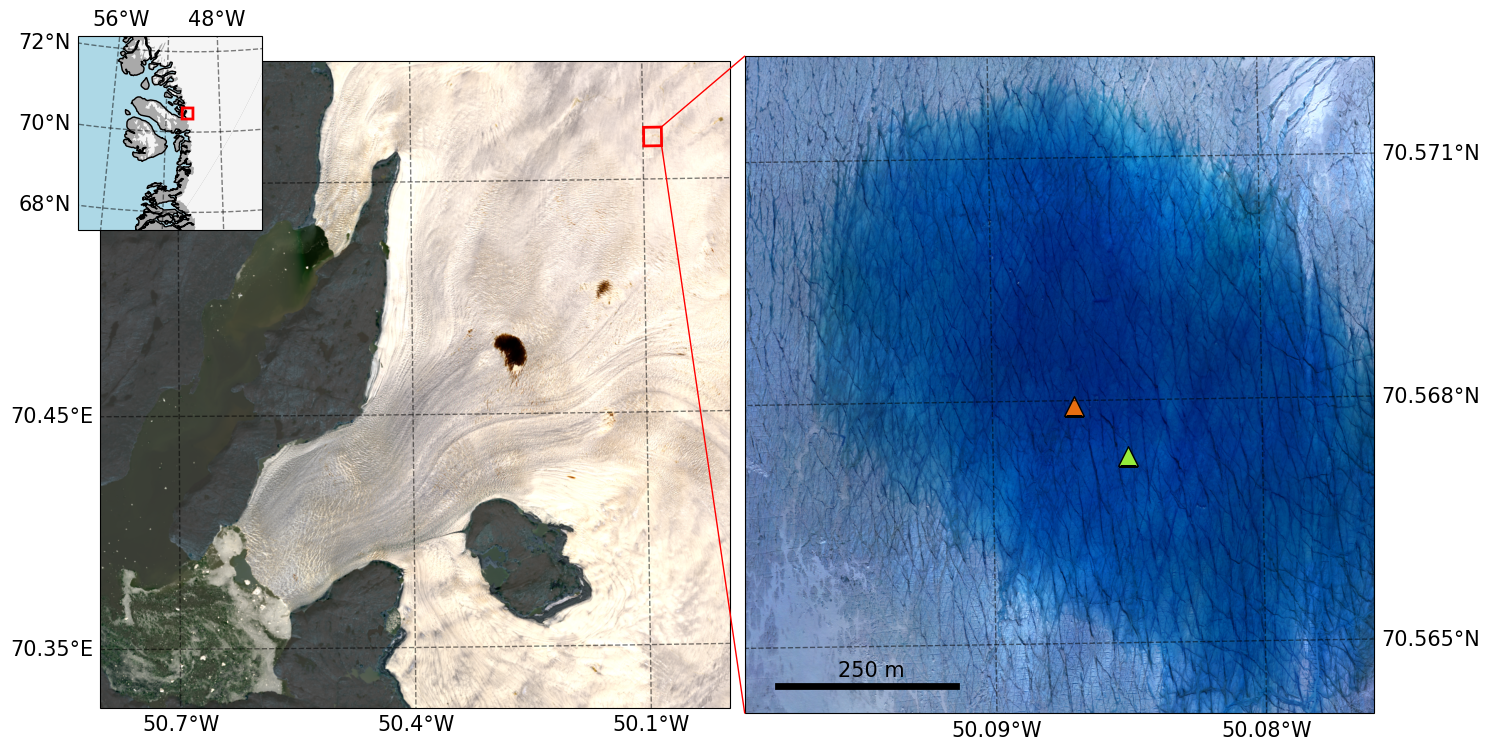

In [13]:
# Path to your Landsat image
sensor = [(-50.08697, 70.56793),(-50.085, 70.5673)]
zoom_1 = [-50.8, -50, 70.325, 70.6]
zoom_2 = [-50.099, -50.076, 70.5642, 70.5722]
path = "/home/solinger/notebooks/greenlanDAS/imagery/"
rgb_images = glob.glob(path+"*B*.TIF")
ortho_image = glob.glob(path+"*.tif")
plot_rgb(rgb_images,ortho_image[0],zoom_1,zoom_2,sensor)

In [36]:
# filepath to the NetCDF file
nc_file = 'BedMachineGreenland-v5.nc'

# load the data
dataset = nc.Dataset(nc_file)
x = dataset.variables['x'][:]
y = dataset.variables['y'][:]
bed = dataset.variables['bed'][:]  # Bed elevation

# create a transformer object for converting from EPSG:3413 to EPSG:4326
transformer = Transformer.from_crs('epsg:4326', 'epsg:3413', always_xy=True)

# transform the coordinates
x_bound, y_bound = transformer.transform(zoom_2[0:2],zoom_2[2:4])
x_sensor, y_sensor = transformer.transform(sensor[0][0], sensor[0][1])

# create a mask for the region of interest
x_mask = (x >= x_bound[0]) & (x <= x_bound[1])
y_mask = (y >= y_bound[0]) & (y <= y_bound[1])

bed_region = bed[np.ix_(x_mask, y_mask)]
x_region = x[x_mask]
y_region = y[y_mask]

# get closest coordinate to sensor
x_ind = np.argmin(np.abs(x_sensor-x_region))
y_ind = np.argmin(np.abs(y_sensor-y_region))

# plotting
plt.plot(bed_region[:,y_ind])

In [2]:
# Filepath to the NetCDF file
nc_file = 'BedMachineGreenland-v5.nc'

# Define the bounds (min lon, max lon, min lat, max lat) around Store Glacier
lon_bounds = [-51, -49] 
lat_bounds = [66, 68] 

# Load the data
dataset = nc.Dataset(nc_file)
x = dataset.variables['x'][:]
y = dataset.variables['y'][:]
bed = dataset.variables['bed'][:]  # Bed elevation

# Create a transformer object for converting from EPSG:3413 to EPSG:4326
transformer = Transformer.from_crs('epsg:3413', 'epsg:4326', always_xy=True)

# Transform the coordinates
#lons, lats = transformer.transform(np.meshgrid(x,y)[0], np.meshgrid(x,y)[1])


In [20]:
np.argmin(np.abs(x_sensor-x))

3097